In [13]:

import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [15]:
import os
def read_datasets():


    # Ensure the files exist before reading
    user_file = r"/content/users.csv"

    fake_user_file =r"/content/fusers.csv"


    if not os.path.exists(user_file) or not os.path.exists(fake_user_file):
        raise FileNotFoundError("One or both dataset files are missing.")

    # Read datasets
    genuine_users = pd.read_csv(user_file)
    fake_users = pd.read_csv(fake_user_file)

    # Combine the datasets
    X = pd.concat([genuine_users, fake_users], ignore_index=True)

    # Assign labels: 1 for genuine users, 0 for fake users
    y = pd.Series([1] * len(genuine_users) + [0] * len(fake_users), name="label")

    # Shuffle data to prevent order bias
    X, y = shuffle(X, y, random_state=42)

    return X, y

In [4]:
!pip install gender-guesser
import gender_guesser.detector as gender
import pandas as pd
import numpy as np


def predict_sex(name):
    """
    Predicts gender based on first names using `gender-guesser`.
    """
    sex_predictor = gender.Detector(case_sensitive=False)
    first_name = name.str.split(' ').str.get(0)

    # Ensure 'first_name' is not empty before prediction
    sex = first_name.apply(lambda n: sex_predictor.get_gender(n) if isinstance(n, str) and n else 'unknown')  # Handle empty strings or NaNs

    sex_dict = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'mostly_male': 1, 'male': 2}
    sex_code = sex.map(sex_dict).fillna(0).astype(int)  # Handle potential NaN values from mapping
    return sex_code

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 5.9 MB/s eta 0:00:00


In [16]:

def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'].dropna())))  # Drop NaN values before mapping
    lang_dict = {name: i for i, name in lang_list}

    x.loc[:, 'lang_code'] = x['lang'].map(lang_dict)
    x.loc[:, 'sex_code'] = predict_sex(x['name'])

    # Fill missing values with a default code (e.g., -1)
    x['lang_code'].fillna(-1, inplace=True)
    x['sex_code'].fillna(0, inplace=True)

    # Convert to integer after handling NaN values
    x['lang_code'] = x['lang_code'].astype(int)
    x['sex_code'] = x['sex_code'].astype(int)

    feature_columns_to_use = [
        'statuses_count', 'followers_count', 'friends_count',
        'favourites_count', 'listed_count', 'sex_code', 'lang_code'
    ]

    x = x.loc[:, feature_columns_to_use]
    return x

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [18]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    target_names = ['Fake', 'Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [19]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print("False Positive Rate:", false_positive_rate)
    print("True Positive Rate:", true_positive_rate)

    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def train(X_train, y_train, X_test):
    """Trains and predicts dataset with a Random Forest classifier"""

    clf = RandomForestClassifier(n_estimators=40, oob_score=True)
    clf.fit(X_train, y_train)

    print("The best classifier is:", clf)

    # Estimate score
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))

    title = 'Learning Curves (Random Forest)'
    plot_learning_curve(clf, title, X_train, y_train, cv=5)
    plt.show()

    # Predict
    y_pred = clf.predict(X_test)

    return y_pred

In [25]:
print("Reading datasets...\n")
x,y = read_datasets()
print(x.describe())
print("Extracting features...\n")


Reading datasets...

                 id  statuses_count  followers_count  friends_count  \
count  2.818000e+03     2818.000000      2818.000000    2818.000000   
mean   5.374889e+08     1672.198368       371.105039     395.363023   
std    2.977005e+08     4884.669157      8022.631339     465.694322   
min    3.610511e+06        0.000000         0.000000       0.000000   
25%    3.620867e+08       35.000000        17.000000     168.000000   
50%    6.162253e+08       77.000000        26.000000     306.000000   
75%    6.177673e+08     1087.750000       111.000000     519.000000   
max    1.391998e+09    79876.000000    408372.000000   12773.000000   

       favourites_count  listed_count  default_profile  default_profile_image  \
count       2818.000000   2818.000000           1728.0                    8.0   
mean         234.541164      2.818666              1.0                    1.0   
std         1445.847248     23.480430              0.0                    0.0   
min            

In [32]:
print("Reading datasets...\n")
x,y = read_datasets()
print(x.describe())
print("Extracting features...\n")

Reading datasets...

                 id  statuses_count  followers_count  friends_count  \
count  2.818000e+03     2818.000000      2818.000000    2818.000000   
mean   5.374889e+08     1672.198368       371.105039     395.363023   
std    2.977005e+08     4884.669157      8022.631339     465.694322   
min    3.610511e+06        0.000000         0.000000       0.000000   
25%    3.620867e+08       35.000000        17.000000     168.000000   
50%    6.162253e+08       77.000000        26.000000     306.000000   
75%    6.177673e+08     1087.750000       111.000000     519.000000   
max    1.391998e+09    79876.000000    408372.000000   12773.000000   

       favourites_count  listed_count  default_profile  default_profile_image  \
count       2818.000000   2818.000000           1728.0                    8.0   
mean         234.541164      2.818666              1.0                    1.0   
std         1445.847248     23.480430              0.0                    0.0   
min            

In [33]:
x = extract_features(x)
print(x.columns)
print(x.describe())
print("Splitting datasets into train and test sets...\n")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=44)

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.191270     2.851313  
std       23.480430     1.68

<ipython-input-16-f3cba1fe7893>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x['lang_code'].fillna(-1, inplace=True)
<ipython-input-16-f3cba1fe7893>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

Training datasets...

The best classifier is: RandomForestClassifier(n_estimators=40, oob_score=True)
[0.99334812 0.99778271 0.99778271 0.99778271 0.99777778]
Estimated score: 0.99689 (+/- 0.00089)


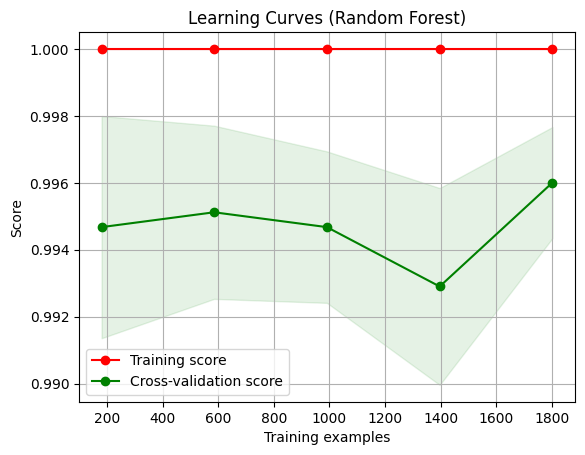

Classification Accuracy on Test dataset: 0.9964539007092199


In [34]:
print("Training datasets...\n")
y_pred = train(X_train, y_train, X_test)
print("Classification Accuracy on Test dataset:", accuracy_score(y_test, y_pred))


Confusion matrix, without normalization
[[274   1]
 [  1 288]]


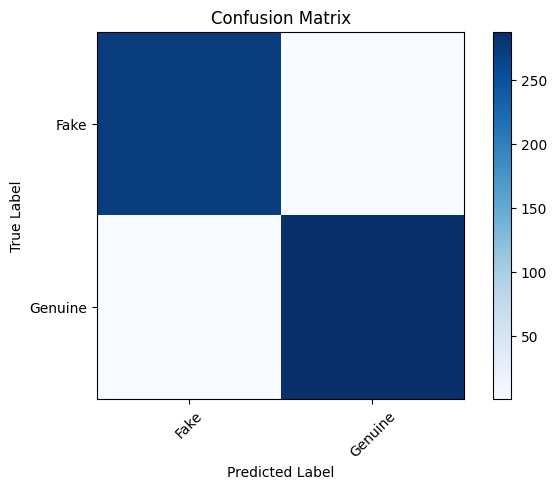

In [23]:

cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)



Normalized confusion matrix
[[0.99636364 0.00363636]
 [0.00346021 0.99653979]]
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       275
     Genuine       1.00      1.00      1.00       289

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564

False Positive Rate: [0.         0.00363636 1.        ]
True Positive Rate: [0.         0.99653979 1.        ]


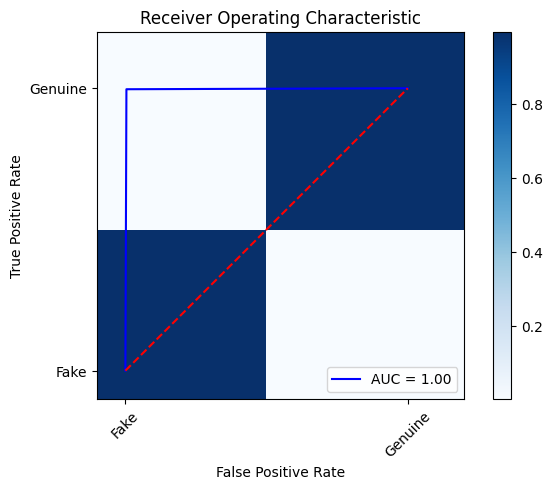

In [24]:

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))
plot_roc_curve(y_test, y_pred)